In [1]:
#Input parameters
Var1 = 0 # {"var1": 2}
weatherStationSerial = "BWEATHER-1"
citySerial = "Loudeac"
pPlantSerial = "JPP-1"
batterySerial = "BAT-1"

In [2]:
!pip install -qqq --upgrade git+https://alroc@bitbucket.org/freemens/ionlib.git@master 

In [3]:
!pip install -qqq --upgrade git+https://bitbucket.org/freemens/ion_sdk.git@master    

In [4]:
%env ALTERGO_FACTORY_API = https://staging.altergo.io/
%env ALTERGO_IOT_API = https://iot.staging.altergo.io/   

env: ALTERGO_FACTORY_API=https://staging.altergo.io/
env: ALTERGO_IOT_API=https://iot.staging.altergo.io/


In [126]:
from ionlib.models.battery import Battery, Cell, LEVEL_MODULE
from ionlib.models.powerplant import PowerPlant 
import pandas as pd
import ion_sdk.edison_api.edison_api as eapi
from ion_sdk.edison_api.models.factoryModel import EdisonGenericComponent, Model,CurrentState
from ion_sdk.tools.toolbox import plotSensors, dataframeFromSensors
from ion_sdk.tools.sim import Sensor
import datetime
from datetime import datetime
import math
from random import random
import numpy as np
from ionlib.specs.powerplant_specs import simSpecs
import pprint

In [127]:
edApi = eapi.Client("f6ad4f7166814976b66b9cb346ebc5dd")
pp = pprint.PrettyPrinter(indent=4)

In [128]:
batteryAsset = edApi.getAsset(batterySerial)

batteryVoltage = 400
batteryCapacity = 50
neededParameters = ["Voltage","Capacity"]
parameterDict = {}
for param in batteryAsset.model.parameters:
    if param.parameter_model.name in neededParameters:
        parameterDict[param.parameter_model.name] = param.parameter_values[0].value
print(parameterDict)


{'Voltage': '400', 'Capacity': '200'}


In [129]:
pp.pprint(simSpecs)

{   'architecture': {   'cellsParallel': 14,
                        'cellsSeries': 13,
                        'dimension': '',
                        'mass': 80,
                        'modulesParallel': 1,
                        'modulesSeries': 9,
                        'name': 'bat1',
                        'stacksParallel': 1,
                        'stacksSeries': 1,
                        'surface': '',
                        'weight': ''},
    'car': {},
    'cell': {   'OCV Table': '{JSON}',
                'cComponent': [0, 5000, 27000],
                'cellCapacity': 4.0,
                'cellChemistry': 'NMC',
                'convectionH': '',
                'convectionSurf': '',
                'cycleLife': 2000,
                'dimension': '',
                'k1': '',
                'k2': '',
                'k3': '',
                'k4': '',
                'mass': 0.06,
                'name': 'cell1',
                'rComponent': [0.02, 0.0115, 0.008],

In [130]:
moduleInSeries = float(parameterDict["Voltage"])/float(simSpecs['cell']['voltage']) / float(simSpecs['architecture']['cellsSeries'])
moduleInSeries = math.ceil(moduleInSeries)

moduleInPar=float(parameterDict["Capacity"])/float(simSpecs['cell']['cellCapacity'])/14
moduleInPar = math.ceil(moduleInPar)

print(moduleInPar)
simSpecs['architecture']["modulesSeries"] = moduleInSeries
simSpecs['architecture']["modulesParallel"] = moduleInPar

4


In [131]:
print(simSpecs)

{'start': 1633564800.0, 'length': 0, 'step': 1, 'serialNumber': 'SW-', 'model': 'Battery A', 'cell': {'name': 'cell1', 'cellChemistry': 'NMC', 'rComponent': [0.02, 0.0115, 0.008], 'cComponent': [0, 5000, 27000], 'voltage': 3.6, 'cellCapacity': 4.0, 'k1': '', 'k2': '', 'k3': '', 'k4': '', 'cycleLife': 2000, 'mass': 0.06, 'surface': 0.025, 'specificHeat': '', 'convectionSurf': '', 'convectionH': '', 'weight': 0.08, 'dimension': '', 'OCV Table': '{JSON}'}, 'architecture': {'name': 'bat1', 'cellsSeries': 13, 'cellsParallel': 14, 'modulesSeries': 9, 'modulesParallel': 4, 'stacksParallel': 1, 'stacksSeries': 1, 'mass': 80, 'surface': '', 'weight': '', 'dimension': ''}, 'weather': {}, 'road': {}, 'car': {}, 'driver': {}}


In [132]:
weatherStationAsset = edApi.getAsset(weatherStationSerial)
sensorNameList = edApi.matchSensors(["Direct radiation"],weatherStationAsset)
req={
    "assets":[weatherStationAsset],
    "sensorNames":sensorNameList,
    "startDate":eapi.edisonDate(2021,10,7,2,00),
    "endDate":eapi.edisonDate(2021,10,15,1,00)
        }

edApi.getAssetDataFrame(**req)

weatherStationDf = weatherStationAsset.df

('Direct radiation', 100)
getting sensors: Direct radiation from: 2021-10-07 00:00:00 UTC to : 2021-10-14 23:00:00 UTC
[##############################] 100%

In [133]:
cityAsset = edApi.getAsset(citySerial)
sensorNameList = edApi.matchSensors(["Power"],cityAsset)
req={
    "assets":[cityAsset],
    "sensorNames":sensorNameList,
    "startDate":eapi.edisonDate(2021,10,7,2,00),
    "endDate":eapi.edisonDate(2021,10,15,1,00)
        }

edApi.getAssetDataFrame(**req)

cityDf = cityAsset.df

('Power', 100)
getting sensors: Power from: 2021-10-07 00:00:00 UTC to : 2021-10-14 23:00:00 UTC
[##############################] 100%

In [134]:
SIM_TARGETED_DEPTH = LEVEL_MODULE
simTime = simSpecs["start"] + 3600 * 24 * 7
t = simSpecs["start"]
dt_s = 60.0
prev_dt_s = 60.0
time = []

pPlant = PowerPlant(sourceProfile = weatherStationDf, loadProfile = cityDf, simSpecs = simSpecs)

|    | Name          | Type   | Conditions    |      Value | Unit   |
|----|---------------|--------|---------------|------------|--------|
|  0 | Cell in S     |        |               |     9      |        |
|  1 | Cell in P     |        |               |    56      |        |
|  2 | Modules in P  |        |               |     4      |        |
|  3 | Modules in S  |        |               |     9      |        |
|  4 | Stacks in P   |        |               |     1      |        |
|  5 | Stacks in S   |        |               |     1      |        |
|  6 | Capacity      | Nom.   | 25°C, C/2     |   224      | A.h    |
|  7 | Voltage       | Nom.   | 25°C, 50% SOC |   432.9    | V      |
|  8 | DC Resistance | Nom.   | 25°C, 50% SOC |     0.0418 | Ohm    |
|  9 | Power Loss    | Typ.   | 1C,50% SOC    |     0      | W      |
| 10 | Short-Circuit | Typ.   | 500us,50% SOC | 10360      | A      |
| 11 | Specific Heat | Typ.   | Lithium cells |   800      | J/K/kg |
| 12 | Mass         

In [135]:
analysedElements = []
pPlant.battery.getElementsByDepth(analysedElements, SIM_TARGETED_DEPTH)

In [136]:
pPlantSensors = {}
batterySensors = {}
loadSensors = {}

pPlantSensors["production potential"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "°",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["demand potential"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "°",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["production actual"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "°",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)
pPlantSensors["power"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "°",
        "axis": 1,
        "synced": 1,
        "plotted": 1,
    }
)


In [137]:
batterySensors["current"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "%",
        "axis": 2,
        "synced": 1,
        "plotted": 1,
    }
)
batterySensors["power"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 3,
        "synced": 1,
        "plotted": 1,
    }
)
batterySensors["soc"] = Sensor(
    **{
        "data": [],
        "time": [],
        "lastSigVal": 0.0,
        "sigVarTh": 0.001,
        "unit": "W",
        "axis": 3,
        "synced": 1,
        "plotted": 1,
    }
)

In [138]:
while t < simTime:
# Manage battery current
    current = pPlant.managePower(t)
    # Simulation time step management
    dt_s = min(
        60.0,
        float(
            pPlant.battery.capacity.init * 3600.0 / (1.0 + abs(current * 400.0))
        ),
    )
    if dt_s > prev_dt_s:
        dt_s = prev_dt_s * 1.2
        if dt_s >= 60.0:
            dt_s = 60.0
    prev_dt_s = dt_s
    
    t = t + dt_s

    pPlant.battery.setCurrent(current, SIM_TARGETED_DEPTH)

    for l in analysedElements:
        l.calculateNextStep(dt_s, 25.0)
    pPlant.battery.soc = min(l.soc for l in analysedElements)
    
    tDate = datetime.fromtimestamp(t)

    batterySensors["soc"].significantAppend(float(pPlant.battery.soc), tDate)
    batterySensors["power"].significantAppend(float(pPlant.pBat), tDate)
    batterySensors["current"].significantAppend(float(current), tDate)
    pPlantSensors["production potential"].significantAppend(float(pPlant.pProductionPot), tDate)
    pPlantSensors["demand potential"].significantAppend(float(pPlant.pDemandPot), tDate)
    pPlantSensors["production actual"].significantAppend(float(pPlant.pProduction), tDate)
    pPlantSensors["power"].significantAppend(float(pPlant.pSupplied), tDate)

In [139]:
batteryDf = dataframeFromSensors(batterySensors)
pPlantDf = dataframeFromSensors(pPlantSensors)

In [140]:
batAsset = edApi.getAsset(batterySerial)
batAsset.df = batteryDf
uploadSensorList = edApi.refactorDataframeToAsset(batAsset.df, batAsset)
edApi.updateSensorDataByFile(batAsset, uploadSensorList)

('Current', 100)
('Power', 100)
('SoC', 100)

Preparing payload
Payload sent successfully! Checkout: https://staging.altergo.io/core/iot/connected_component/view/319/graph


In [141]:
pPlantAsset = edApi.getAsset(pPlantSerial)
pPlantAsset.df = pPlantDf

uploadSensorList = edApi.refactorDataframeToAsset(pPlantAsset.df, pPlantAsset)
edApi.updateSensorDataByFile(pPlantAsset, uploadSensorList)


('Demand potential', 100)
('Power', 100)
('Production actual', 100)
('Production potential', 100)

Preparing payload
Payload sent successfully! Checkout: https://staging.altergo.io/core/iot/connected_component/view/318/graph


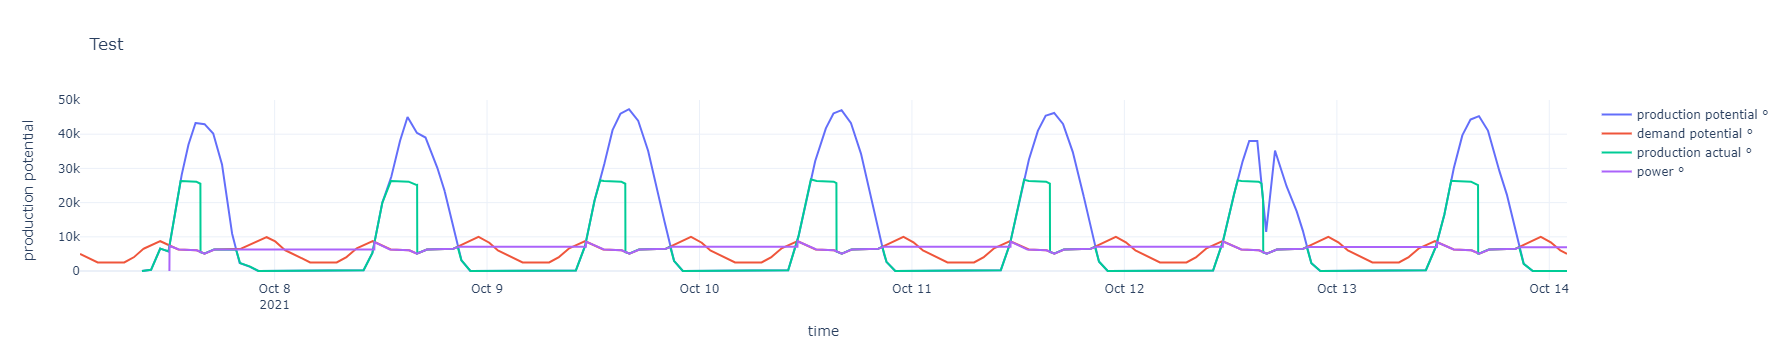

In [142]:
df = dataframeFromSensors(pPlantSensors)
fig = plotSensors(pPlantSensors, df, "Test")
fig.show()